In [ ]:
"""Visualize 2D convolution outputs for QC and inspection."""

In [1]:
import os
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import skimage
import tifffile
from skimage import io

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()
if in_notebook:
    from tqdm.notebook import tqdm
else:
    import tqdm

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
if not in_notebook:
    args = parse_args()
    window_size = args["window_size"]
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        window_size=window_size,
        clip_limit=clip_limit,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-2"
    window_size = 3
    clip_limit = 0.05


input_dir_raw = pathlib.Path(
    f"{image_base_dir}/data/{patient}/zstack_images/{well_fov}"
).resolve(strict=True)
input_dir_decon = pathlib.Path(
    f"{image_base_dir}/data/{patient}/deconvolved_images/{well_fov}"
).resolve(strict=True)

Running in a notebook


In [3]:
# read in the image
list_of_decon_images = list(input_dir_decon.glob("*.tif"))
list_of_raw_images = list(input_dir_raw.glob("*.tif"))
list_of_decon_images.sort()
list_of_raw_images.sort()

In [4]:
convolutions = 25
convolution_step = 1

In [5]:
img_dict = {
    "decon": list_of_decon_images,
    "raw": list_of_raw_images,
}
for convolution in range(1, convolutions + 1):
    img_dict[f"convolved_{convolution}"] = []
for img_path in tqdm(list_of_decon_images, desc="Processing image set"):
    for convolution in tqdm(
        range(1, convolutions + 1), desc="Convolving image", leave=False
    ):
        if (convolution) % convolution_step == 0:
            convolution_output_path = pathlib.Path(
                f"{image_base_dir}/data/{patient}/convolution_{convolution}/{well_fov}"
            ).resolve()
            if convolution % 5 == 0:
                img_dict[f"convolved_{convolution}"].append(
                    convolution_output_path / f"{img_path.name}"
                )

Processing image set:   0%|          | 0/4 [00:00<?, ?it/s]

Convolving image:   0%|          | 0/25 [00:00<?, ?it/s]

Convolving image:   0%|          | 0/25 [00:00<?, ?it/s]

Convolving image:   0%|          | 0/25 [00:00<?, ?it/s]

Convolving image:   0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
number_of_channels = len(img_dict["decon"])
number_of_columns = 1 + 1 + convolutions // 5

In [7]:
new_dict = {"405": [], "488": [], "555": [], "640": []}
for image_type in img_dict:
    for channel in img_dict[image_type]:
        if "405" in channel.name:
            new_dict["405"].append(channel)
        elif "488" in channel.name:
            new_dict["488"].append(channel)
        elif "555" in channel.name:
            new_dict["555"].append(channel)
        elif "640" in channel.name:
            new_dict["640"].append(channel)

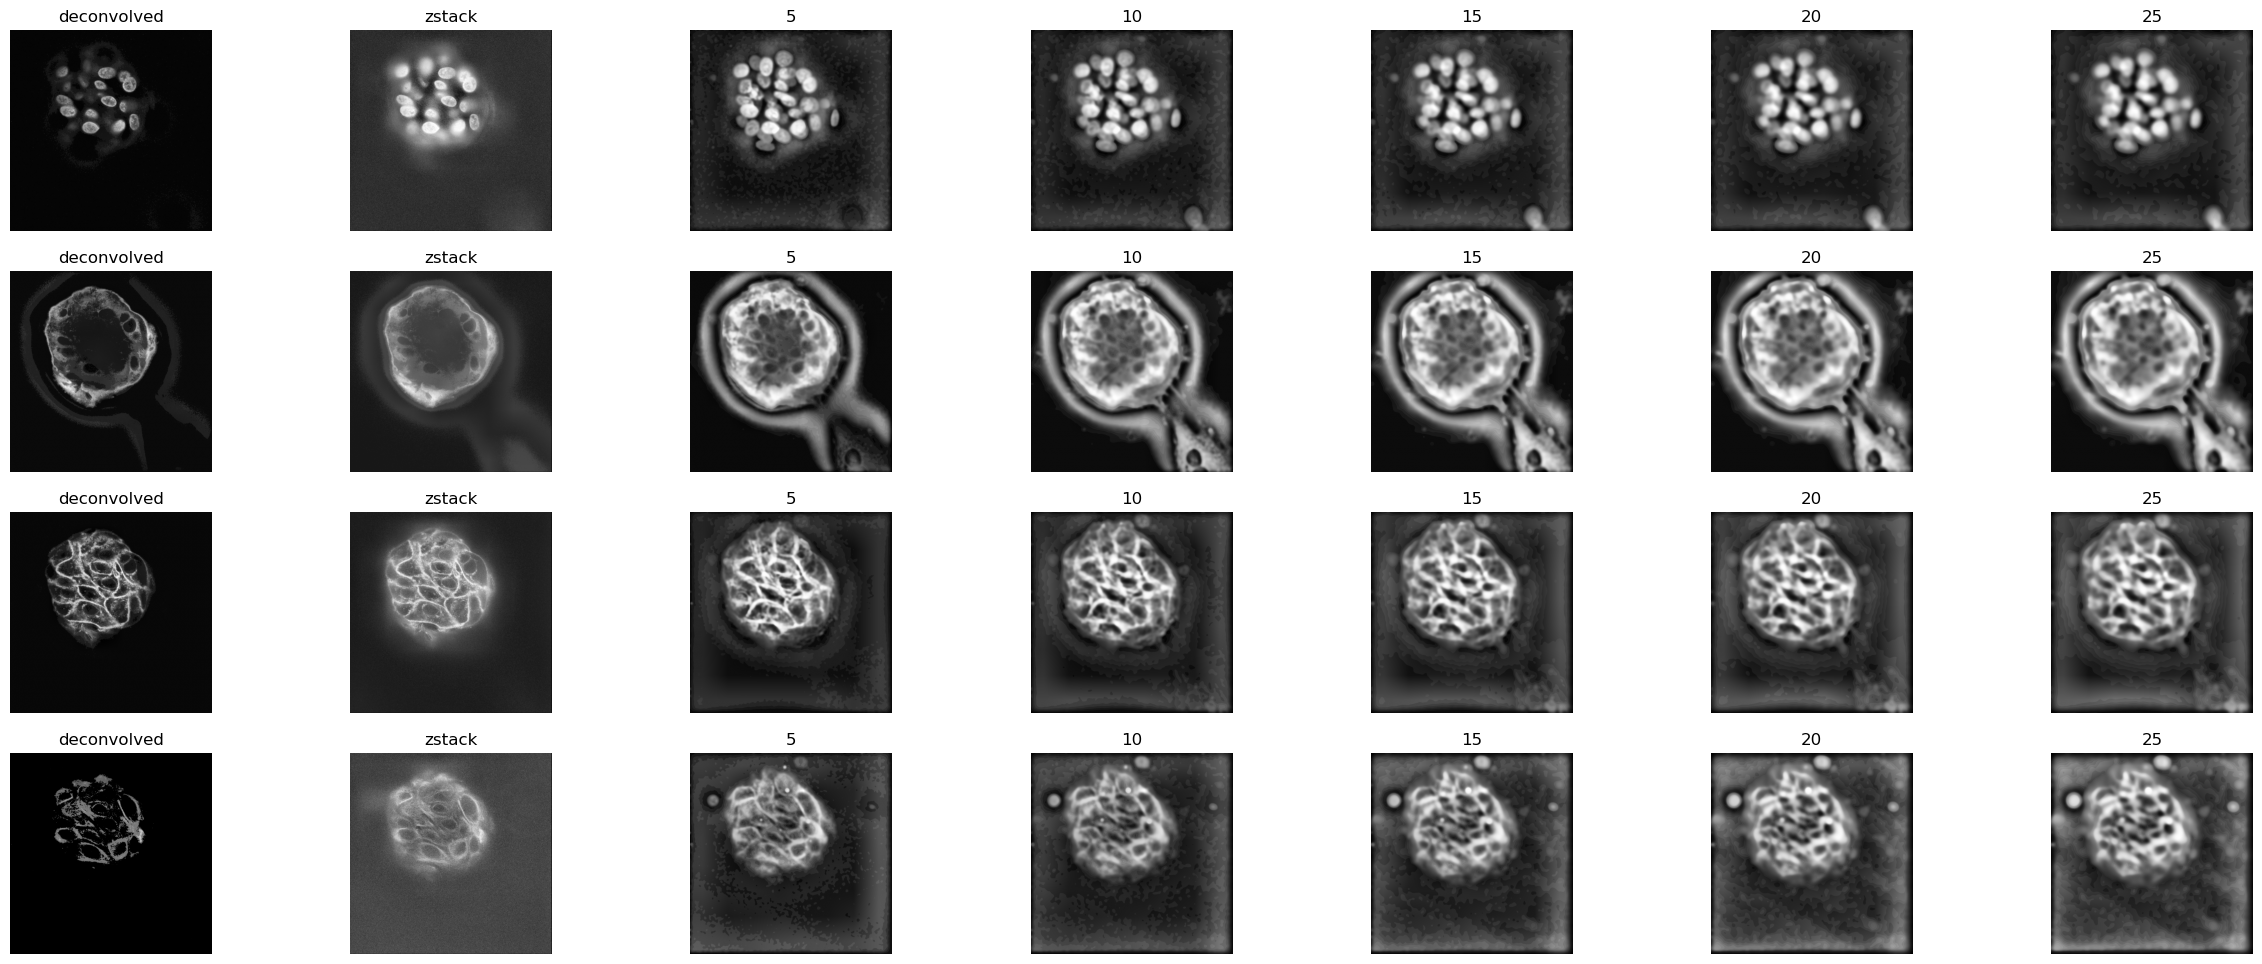

In [8]:
plt.figure(figsize=(30, 12))
for i, channel in enumerate(new_dict):
    image_type = channel
    titles = [
        f"{str(channel_img_path).split('/')[-3].split('_')[0]}"
        if "deconvolved" in str(channel_img_path) or "zstack" in str(channel_img_path)
        else f"{str(channel_img_path).split('/')[-3].split('_')[1]}"
        for j, channel_img_path in enumerate(new_dict[image_type])
    ]

    for j, channel_img_path in enumerate(new_dict[image_type]):
        plt.subplot(
            number_of_channels, number_of_columns, i * number_of_columns + j + 1
        )
        img = read_zstack_image(channel_img_path)
        img = skimage.exposure.equalize_adapthist(
            img,
            clip_limit=clip_limit,
        )
        plt.imshow(
            img[img.shape[0] // 2, :, :],
            cmap="gray",
        )
        plt.axis("off")
        plt.title(titles[j])
plt.show()